## Upper Confidence Bound (UCB) Selection

In this demo, we will simulate a practical application of Multi-Armed Bandits. There are 10 different advertisements, that were repeated for 10,000 rotations. The agent has to select one advertisement amongst 10 for placement, the dataset describes whether the picked advertisement would be clicked(1) or not (0). Let us compare Epsilon Greedy and UCB methods for this problem.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import math
%matplotlib inline

In [2]:
dataset = pd.read_csv("ads.csv")

In [3]:
dataset.head()

,Ad 1,Ad 2,Ad 3,Ad 4,Ad 5,Ad 6,Ad 7,Ad 8,Ad 9,Ad 10
0,1,0,0,0,1,0,0,0,1,0
1,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0


In [4]:
def choose_random_ad(dataset):
    num_episodes = dataset.shape[0]
    num_ads      = dataset.shape[1]
    ads_selected  =[]
    total_reward = 0
    rewards      = np.zeros(num_episodes)
    last_100_rewards = np.zeros(num_episodes)
    ads_selection = np.zeros((num_ads, num_episodes))
    
    
     
    for n in range(0, num_episodes):
        ad = random.randrange(num_ads)
        ads_selected.append(ad)
        reward = dataset.values[n, ad]

         # Update the reward given    
        total_reward = total_reward + reward
        rewards[n] = reward

        # Update the running average
        if n > 100:
            last_100_rewards[n] = rewards[np.arange(n-99,n+1)].mean()

        # Update the ads selection for each ad
        if n > 0:
            for i in range(0, num_ads):
                ads_selection[i][n] = ads_selection[i][n-1]
            ads_selection[ad][n] = ads_selection[ad][n-1] + 1

   

    return ads_selected, last_100_rewards, ads_selection,total_reward


In [5]:
ads_selected, last_100_rewards, ads_selection,total_reward = choose_random_ad(dataset)
print(total_reward)

1226


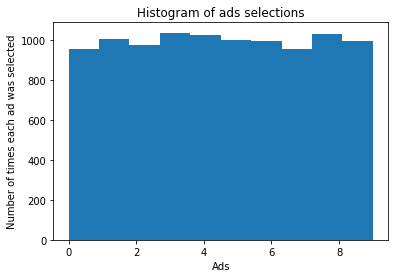

In [6]:
    # Histogram of amount of times an ad was selected
    plt.hist(ads_selected)
    plt.title('Histogram of ads selections')
    plt.xlabel('Ads')
    plt.ylabel('Number of times each ad was selected')
    plt.show()

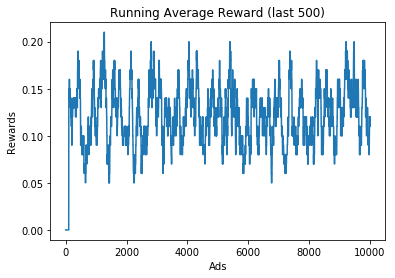

In [7]:
# Running average of rewards
plt.plot(last_100_rewards)
plt.title('Running Average Reward (last 500)')
plt.xlabel('Ads')
plt.ylabel('Rewards')
plt.show()

In [8]:
def return_epsilon_greedy_action(epsilon, reward_counter_array):
    
    tot_actions = reward_counter_array.shape[0]
    if random.uniform(0, 1) <= epsilon:
        action = np.random.randint(low=0, high=tot_actions)
    else:
        amax = np.amax(reward_counter_array)
        indices = np.where(reward_counter_array == amax)[0]
        action = np.random.choice(indices)
    return action

In [9]:
def choose_epsilon_greedy_ads(dataset,epsilon=0.1):
    num_episodes = dataset.shape[0]
    num_ads      = dataset.shape[1]
    ads_selected  =[]
    num_ad_selected = np.zeros(num_ads)
    
    total_reward = 0
    rewards      = np.zeros(num_episodes)
    avg_rewards  = np.zeros(num_ads)
    num_ad_rewards = np.zeros(num_ads)
    num_ad_win = np.zeros(num_ads)
    last_100_rewards = np.zeros(num_episodes)
    ads_selection = np.zeros((num_ads, num_episodes))
    
    for n in range(0,num_episodes):
        ad = return_epsilon_greedy_action(epsilon,avg_rewards)
        ads_selected.append(ad)
        reward = dataset.values[n, ad]
        rewards[n] = reward
        num_ad_selected[ad] = num_ad_selected[ad] + 1
        num_ad_win[ad] = num_ad_win[ad] + reward
        avg_rewards[ad] = num_ad_win[ad] / num_ad_selected[ad]
        total_reward = total_reward + reward


        # Update the Running average
        if n > 100:
            last_100_rewards[n] = rewards[np.arange(n-99,n+1)].mean()
            
            # Update the ads selection for each ad
        if n > 0:
            for i in range(0, num_ads):
                ads_selection[i][n] = ads_selection[i][n-1]
            ads_selection[ad][n] = ads_selection[ad][n-1] + 1
            
    return ads_selected, last_100_rewards, ads_selection,total_reward
        
    
    

In [10]:
ads_selected, last_100_rewards, ads_selection,total_reward = choose_epsilon_greedy_ads(dataset)
print(total_reward)

2389


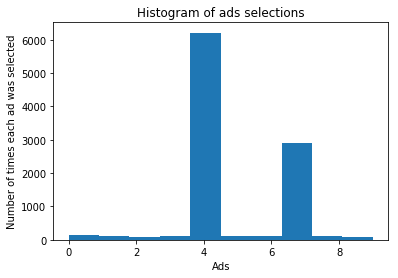

In [11]:
plt.hist(ads_selected)
plt.title('Histogram of ads selections')
plt.xlabel('Ads')
plt.ylabel('Number of times each ad was selected')
plt.show()

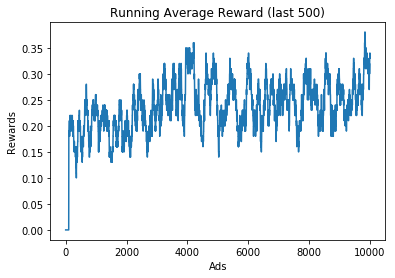

In [12]:
plt.plot(last_100_rewards)
plt.title('Running Average Reward (last 500)')
plt.xlabel('Ads')
plt.ylabel('Rewards')
plt.show()

In [13]:
def return_ubc_action(num_arms,num_selections,rewards_array):
    max_upper_bound = 0
    for i in range(0,num_arms):
        if (num_selections[i] > 0):
            average_reward = rewards_array[i]/num_selections[i]
            delta_i = math.sqrt(3/2 * math.log(num_arms+1)/num_selections[i])
            upper_bound = average_reward + delta_i
        else:
            upper_bound = 1e4000
        
        if upper_bound > max_upper_bound:
            max_upper_bound = upper_bound
            action =i
    return action
        

In [14]:
def choose_by_ubc(dataset):
    num_episodes = dataset.shape[0]
    num_ads      = dataset.shape[1]
    ads_selected  =[]
    num_ad_selected = np.zeros(num_ads)
    
    total_reward = 0
    rewards      = np.zeros(num_episodes)
    avg_rewards  = np.zeros(num_ads)
    num_ad_rewards = np.zeros(num_ads)
    
    sum_ad_rewards = np.zeros(num_ads)
    last_100_rewards = np.zeros(num_episodes)
    ads_selection = np.zeros((num_ads, num_episodes))
    
    for n in range(0,num_episodes):
        ad = return_ubc_action(num_ads,num_ad_selected,sum_ad_rewards)
        
        # Update the ad tracking vars        
        ads_selected.append(ad)
        num_ad_selected[ad] = num_ad_selected[ad] + 1
        reward = dataset.values[n, ad]
        rewards[n] = reward

       
        
        sum_ad_rewards[ad] = sum_ad_rewards[ad] + reward
        avg_rewards[ad] = num_ad_rewards[ad] / num_ad_selected[ad]
        total_reward = total_reward + reward


        # Update the Running average
        if n > 100:
            last_100_rewards[n] = rewards[np.arange(n-99,n+1)].mean()
            
            # Update the add selection for each ad
        if n > 0:
            for i in range(0, num_ads):
                ads_selection[i][n] = ads_selection[i][n-1]
            ads_selection[ad][n] = ads_selection[ad][n-1] + 1
            
    return ads_selected, last_100_rewards, ads_selection,total_reward
        
    
    


In [16]:
 ads_selected, last_100_rewards, ads_selection,total_reward = choose_by_ubc(dataset)
print(total_reward)

2547


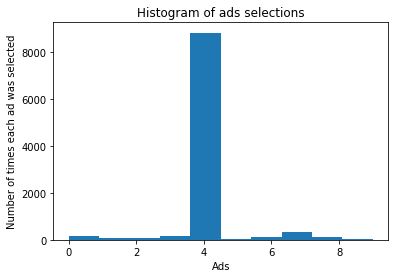

In [17]:
plt.hist(ads_selected)
plt.title('Histogram of ads selections')
plt.xlabel('Ads')
plt.ylabel('Number of times each ad was selected')
plt.show()

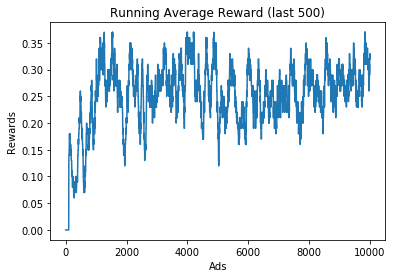

In [18]:
plt.plot(last_100_rewards)
plt.title('Running Average Reward (last 500)')
plt.xlabel('Ads')
plt.ylabel('Rewards')
plt.show()

In [19]:
print(total_reward)

2547
